In [81]:
import math
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import pandas as pd
from os import mkdir, path
import statsmodels.formula.api as smf
from scipy.interpolate import UnivariateSpline
from matplotlib import rc
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, Binarizer
from sklearn.pipeline import make_pipeline
from scipy.optimize import minimize

import pandas as pd

%matplotlib inline

In [82]:
plt.close('all')


rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("ticks")
sns.axes_style()

{'axes.axisbelow': True,
 'axes.edgecolor': '.15',
 'axes.facecolor': 'white',
 'axes.grid': False,
 'axes.labelcolor': '.15',
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': '.8',
 'grid.linestyle': '-',
 'image.cmap': 'rocket',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': '.15',
 'xtick.bottom': True,
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False}

In [83]:
saving = True
figsize = (12, 10)

dirname = "../prebuiltimages/"
imageformat = '.pdf'

if not path.exists(dirname):
    mkdir(dirname)

def my_saving_display(fig, dirname, filename, imageformat):
    """"Saving with personal function."""
    filename = filename.replace('.', 'pt')  # remove "." to avoid floats issues
    if saving is True:
        dirname + filename + imageformat
        image_name = dirname + filename + imageformat
        fig.savefig(image_name)

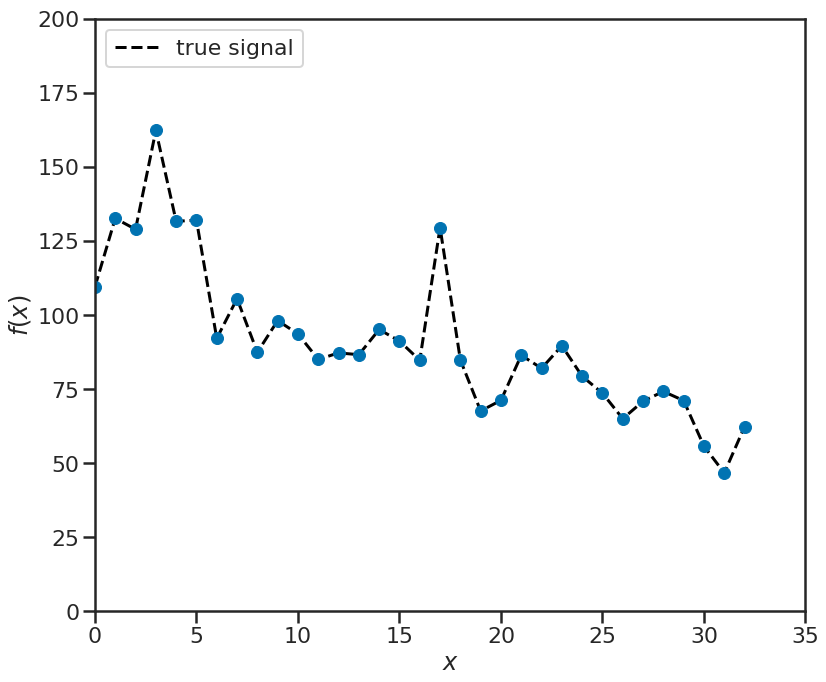

In [95]:
np.random.seed(seed=42)
n_samples = 60
sigma = 0.2  # noise level


F=[109.5,132.6,128.9,162.3,131.6,132.0,92.1,105.5,87.4,98.1,93.6,85.0,87.2,86.6,
95.1,91.2,84.7,129.5,84.8,67.6,71.2,86.4,82.0,89.6,79.3,73.6,65.0,70.9,74.2,71.1,
55.7,46.7,62.3]

x = np.array([i for i in range(len(F))])
xx = np.linspace(0, 32, 33)

def f(X):
    return [F[int(x)] for x in X]


y = f(x)

# Ploting Signal / Noise
fig = plt.figure(figsize=figsize)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim([0, 200])
plt.xlim([0, 35])
plt.plot(xx, f(xx), '--k', label="true signal")
plt.legend(loc='upper left')
plt.tight_layout()
my_saving_display(fig, dirname, "sin_signal", imageformat)
plt.plot(x, y, 'o', label="noisy observations")
my_saving_display(fig, dirname, "sin_signal_noisy", imageformat)
plt.show()

In [85]:
# Performing OLS
X = x[:, np.newaxis]
XX = xx[:, np.newaxis]
ols = LinearRegression(fit_intercept=True)
y_pred = ols.fit(X, y).predict(X)


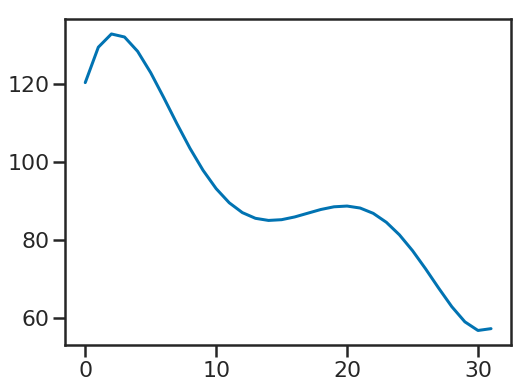

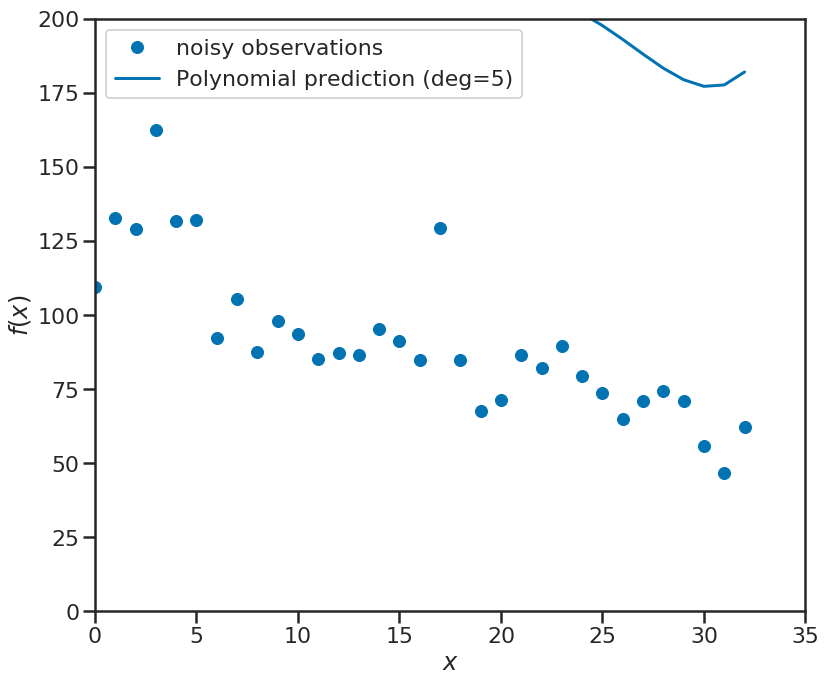

In [98]:
degree = 5

# preprocess for creating polynomials on train and test
poly = PolynomialFeatures(degree)
X_train = poly.fit_transform(X)
X_test = poly.fit_transform(XX)

# Ordinary Least Square step:
ols = LinearRegression(fit_intercept=True)
ols.fit(X_train, y)
coef = ols.coef_
coef[0]=ols.intercept_
y_pred = ols.predict(X_test)

def polynomial_pred(x):
    res=0
    for i in range(len(coef)):
        res += (x**i) * coef[i]
    return res
xxx=[i for i in range(32)]
yyy=[polynomial_pred(i) for i in xxx]
plt.plot(xxx,yyy)
    
    
# Display:
fig = plt.figure(figsize=figsize)
plt.plot(x, y, 'o', label="noisy observations")
plt.plot(xx, y_pred, '-',
         color=sns.color_palette("colorblind", 8)[0],
         label=r"Polynomial prediction (deg={0})".format(degree))
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim([0, 200])
plt.xlim([0, 35])
plt.legend(loc='upper left')
plt.tight_layout()
my_saving_display(fig, dirname, "sin_signal_poly" + str(degree),
                      imageformat)
plt.show()

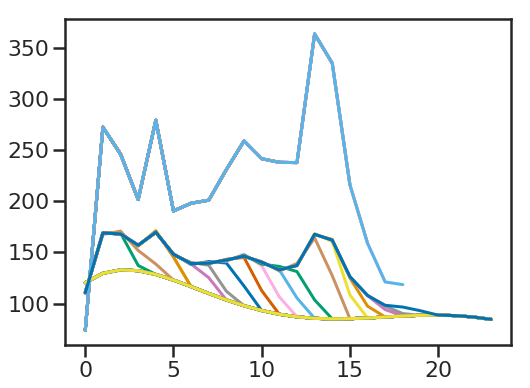

In [103]:
def tridiag(n,s1,s2):
    return np.array([[s1*(abs(i-j)==0)+s2*(abs(i-j)==1) for j in range(n)] for i in range(n)])

def ps(n,a,b): 
    assert(len(a)>=n and len(b)>=n)
    res=0
    for k in range(n):
        res+=a[k]*b[k]
    return res


def predict(tendancy, sigma_tendancy_1, sigma_tendancy_2, raw_data, sigma_data_1, sigma_data_2):
    args= {0 : tendancy, 1 : sigma_tendancy_1, 2 : sigma_tendancy_2, 
            3 : raw_data, 4 : sigma_data_1, 5 : sigma_data_2}
    C=args[0]
    S=tridiag(dim,args[1], args[2])
    X=args[3]
    k=len(X)
    R=tridiag(k,args[4],args[5])
    
    def to_minimize(mu):
        return ps(k,X-mu[:k],np.dot(np.linalg.inv(R),X-mu[:k])) + ps(dim,mu-C,np.dot(np.linalg.inv(S),mu - C))

    res=minimize(to_minimize,np.array([10 for i in range(dim)]))
    plt.plot(range(dim),C)
    plt.plot(range(k),X)
    plt.plot(range(24),res.x)


dim=24

#def polynomial_fit(x):
#    return 110.0269 + 28.85065*x - 7.991107*x**2 + 0.6511692*x**3 - 0.01664595*x**4

#C=[-(x-(dim//2))**2+(dim//2)**2 for x in range(dim)]
C=[polynomial_pred(x) for x in range(dim)]


s1=2
s2=1
r1=5
r2=2
Data=np.array([73.7, 272.3, 246.1, 201.6, 279.1, 190.5, 198.0, 201.0, 230.9, 258.9, 241.5, 238.0, 237.7, 363.4, 334.8,
216.1, 158.9, 121.1, 118.5, 129.4, 107.3, 114.5, 104.9, 123.9, 107.7, ])

for length in range(3,20):
#predict(C,s1,s2,Data,s1,s2)
    predict(C,s1, s2 ,Data[:length], r1, r2)

In [88]:
# defining a class for Polynonial Regression


class PolynomialRegression(LinearRegression):
    """PolynomialRegression Class, to perform for instance CV"""

    def __init__(self, degree=2):
        super(PolynomialRegression, self).__init__()
        self.degree = degree
        self.fit_intercept = True

    def fit(self, X, y, degree=None):
        # preprocess for creating polynomial on train and test
        poly = PolynomialFeatures(self.degree)
        X_train = poly.fit_transform(X)

        super(PolynomialRegression, self).fit(X_train, y)
        return self

    def predict(self, X):
        poly = PolynomialFeatures(self.degree)
        X_test = poly.fit_transform(X)
        return super(PolynomialRegression, self).predict(X_test)

(33, 1)
[546.1783925456347, 400.62125108504097, 2367.3167601222076, 7801.194383512031, 58141.27427791289, 181884.57522197135, 15585.994279818291, 5354.683472625716, 43940830.724881746, 273503412.778843]


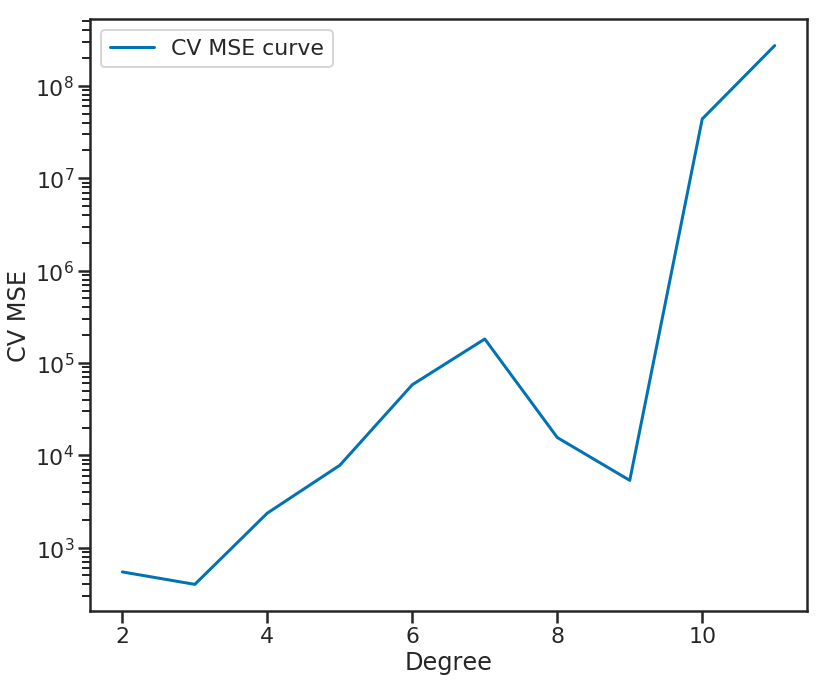

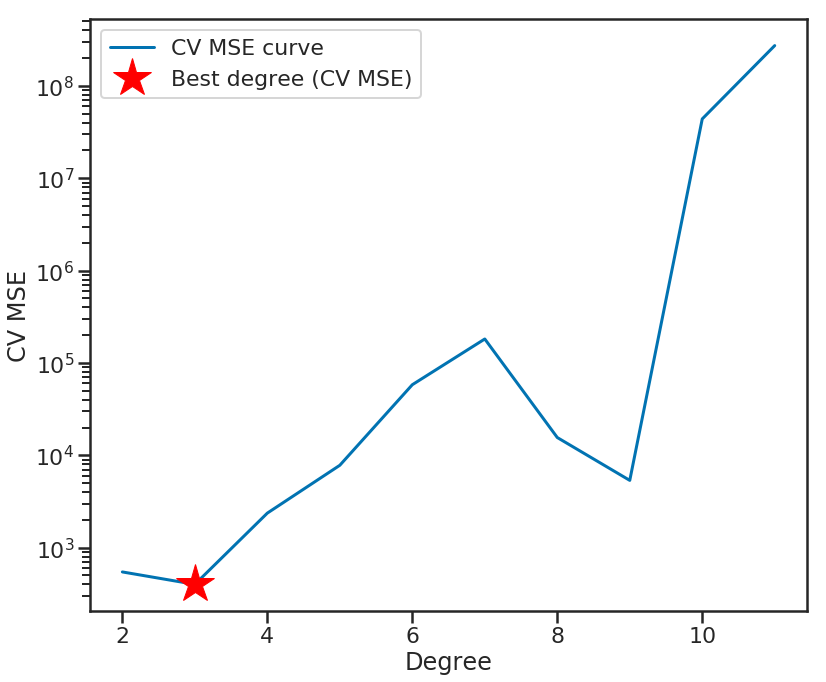

In [89]:
# On the importance of cross-validation

estimator = PolynomialRegression()
degrees = np.arange(2, 12)
cv_model = GridSearchCV(estimator, cv=5,
                        param_grid={'degree': degrees},
                        scoring='neg_mean_squared_error')
# Note: in scoring above, neg means -MSE
cv_model.fit(X, y)
mse = [-cv_score for cv_score in cv_model.cv_results_['mean_test_score']]
print(X.shape)
fig = plt.figure(figsize=figsize)
plt.semilogy(degrees, mse, label="CV MSE curve")
plt.xlabel('Degree')
plt.ylabel('CV MSE')
plt.legend(loc='upper left')
plt.tight_layout()

my_saving_display(fig, dirname, "CV_curve_polynomial", imageformat)

fig = plt.figure(figsize=figsize)
plt.semilogy(degrees, mse, label="CV MSE curve")
plt.xlabel('Degree')
plt.ylabel('CV MSE')
plt.legend(loc='upper left')
plt.tight_layout()
best_idx = np.argmax(cv_model.cv_results_['mean_test_score'])
best_deg = degrees[best_idx]
best_mse = -cv_model.cv_results_['mean_test_score'][best_idx]
plt.plot(best_deg, best_mse, "*r", markersize=40, label="Best degree (CV MSE)")
plt.legend(loc="upper left")
plt.tight_layout()

my_saving_display(fig, dirname, "CV_curve_and_best_polynomial", imageformat)
print(mse)